
#### Этот блокнот пример для того чтобы разобраться с расчетом binary_crossentropy и некоторых других метрик и функций потерь

Мой интерес вызвало то, что binary_crossentropy для цифры MNIST заданной яркостями пикселя от 0 до 1 всегда будет ненулевой.
1) Проблема в том что binary_crossentropy для яркости != 0 или 1 будет не нулевая.
Это видно 
2) Сама функция binary_crossentropy несимметрична. При прочих равных меньший штрафной бал получает более низкая (менее интенсивная) яркость. Описание этого есть в статье ниже со SO.

Но тем не менее эта функция потерь используется чаще. Можно попробовать другие функции (например MSE). И вроде бы на сигмоидных функциях активации это будет работать лучше бинарной кросс-энтропии. Но для Relu показывает себя хуже.



Интересные ссылки:
https://stats.stackexchange.com/questions/245448/loss-function-for-autoencoders/296277#296277


In [79]:
import datetime

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

# import tensorflow

from tensorflow import keras

from tensorflow.keras.layers import Input, Dense, Layer
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

from tensorflow.keras.losses import binary_crossentropy
# from tensorflow.keras.metrics import binary_crossentropy
# from keras.activations import leaky_relu

from tensorflow.keras.layers import LeakyReLU


from tensorflow.keras.optimizers import Adam, RMSprop

# from keras.objectives import binary_crossentropy
# from keras.layers.advanced_activations import LeakyReLU

# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()

from data.get_data import get_mnist
from visualization.plot_graph import plot_digits

%matplotlib inline

In [80]:
x_train, y_train, x_test, y_test = get_mnist()

In [81]:
# Модель где изображение подается без изменений
input_img = tf.keras.Input(shape=(28, 28, 1))
model = tf.keras.Model(input_img, input_img)


# model.compile(optimizer='adam', loss='mse')
model.compile(optimizer='adam', loss='binary_crossentropy')

# Define the input and target images
# input_image = np.random.random((1, 28, 28, 1))
# target_image = np.random.random((1, 28, 28, 1))

# Одинаковые числа
input_image = x_train[:5]
target_image = x_train[:5]

rez_image = model.predict(input_image)

# проверяем какой выдает loss (на самом деле можно напрямую, пример ниже)
loss = model.evaluate(input_image, target_image, return_dict=True)
loss2 = model.evaluate(input_image, rez_image, return_dict=True)
print(loss, loss2)  #

1/1 [==============================] - 0s 22ms/step - loss: 0.0591
{'loss': 0.05913907289505005} {'loss': 0.05913907289505005}


### binary_crossentropy

In [82]:
batch_size = input_image.shape[0]

# можно посчитать через решэйп и затем надо отмасштабировать 
# с учетом что это картинки 28 на 28
x1 = K.reshape(input_image, shape=(batch_size, 28*28))
x2 = K.reshape(target_image, shape=(batch_size, 28*28))
print("Reshaped batch images", x1.shape)

bce_loss_1 = 28 * 28 *keras.losses.binary_crossentropy(x1, x2)

# Ну или просуммировать через tf.reduse_sum
x1 = input_image
x2 = target_image
print("Original batch images",x1.shape)

bce_loss_2_raw = keras.losses.binary_crossentropy(x1, x2)
bce_loss_2 = tf.reduce_sum(bce_loss_2_raw, axis=(1, 2))

# будет одно и то же
print("Results are the same")
print(bce_loss_1) 
print(bce_loss_2)

# Если требуется првести все к одной цифре, то потом усредняем
print("Mean result",tf.reduce_mean(bce_loss_2))


Reshaped batch images (5, 784)
Original batch images (5, 28, 28, 1)
Results are the same
tf.Tensor([51.940235 56.928974 50.91382  28.222256 43.81991 ], shape=(5,), dtype=float32)
tf.Tensor([51.94024  56.92897  50.91382  28.222256 43.81991 ], shape=(5,), dtype=float32)
Mean result tf.Tensor(46.36504, shape=(), dtype=float32)


### binary_crossentropy

In [83]:
x1 = input_image
x2 = target_image
print("Original batch images",x1.shape)

mse_loss_raw = keras.losses.mse(x1, x2)
mse_loss = tf.reduce_sum(mse_loss_raw, axis=(1, 2))

print("MSE Loss",mse_loss)

Original batch images (5, 28, 28, 1)
MSE Loss tf.Tensor([0. 0. 0. 0. 0.], shape=(5,), dtype=float32)


# Diffrences of the same
* Original
* The same
* binary_crossentropy
* mse

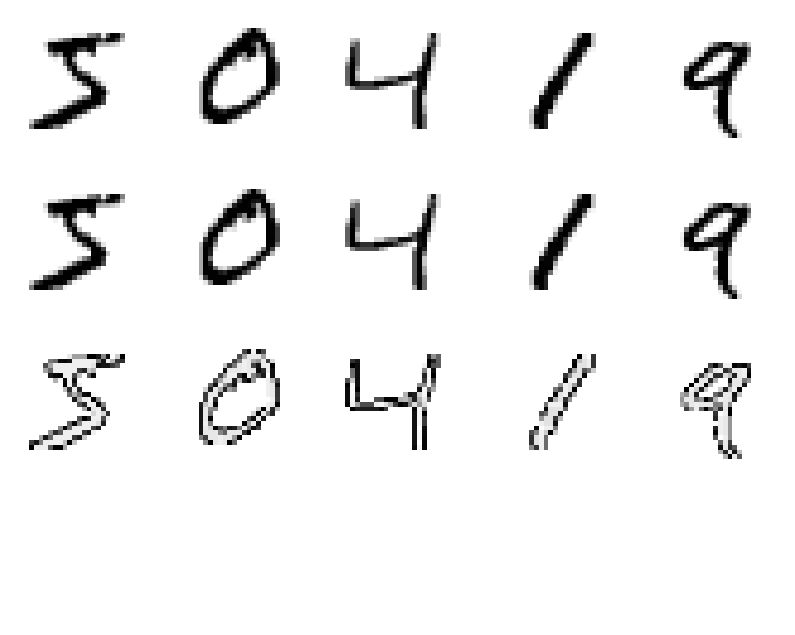

In [84]:
plot_digits(
    input_image,
    target_image,
    bce_loss_2_raw.numpy(),
    mse_loss_raw.numpy(),
    )

# Diffrences of the diffrents
* Original
* The same
* binary_crossentropy
* mse

In [85]:
x1 = x_train[:5]
x2 = x_train[1:6]


bce_loss_diff_raw = keras.losses.binary_crossentropy(x1, x2)
bce_loss_diff = tf.reduce_sum(bce_loss_diff_raw, axis=(1, 2))

print("BCE Loss",bce_loss_diff)
print("Mean BCE result",tf.reduce_mean(bce_loss_diff))


mse_loss_diff_raw = keras.losses.mse(x1, x2)
mse_loss_diff = tf.reduce_sum(mse_loss_diff_raw, axis=(1, 2))

print("MSE Loss",mse_loss_diff)
print("Mean MSE result",tf.reduce_mean(mse_loss_diff))

BCE Loss tf.Tensor([ 835.11414 1670.6028  1186.1118   771.1179   657.00854], shape=(5,), dtype=float32)
Mean BCE result tf.Tensor(1023.991, shape=(), dtype=float32)
MSE Loss tf.Tensor([ 87.63248 129.23972 101.70143  87.75771  80.81352], shape=(5,), dtype=float32)
Mean MSE result tf.Tensor(97.42897, shape=(), dtype=float32)


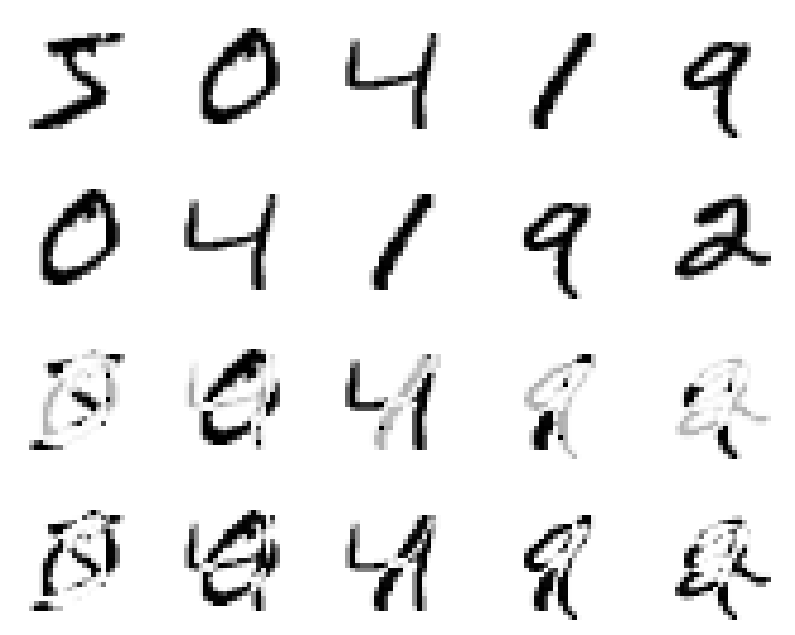

In [86]:
plot_digits(
    x1,
    x2,
    bce_loss_diff_raw.numpy(),
    mse_loss_diff_raw.numpy(),
    )

На примере выше как раз и видна несимметричность binary_crossentropy.
Большая яркость (меньшее значение потерь) там где белое вместо черного. Там где черное идет вместо белого - там яркость ниже (значение меньше)

С другой стороны binary_crossentropy оказывается лучше там где яркость фигуры просто смещена.
Пример ниже:

BCE Loss tf.Tensor([795.3906  876.2382  729.19055 441.80835 637.4402 ], shape=(5,), dtype=float32)
Mean BCE result tf.Tensor(696.0136, shape=(), dtype=float32)
MSE Loss tf.Tensor([80.2236   91.706894 54.063248 51.122177 67.912575], shape=(5,), dtype=float32)
Mean MSE result tf.Tensor(69.00569, shape=(), dtype=float32)


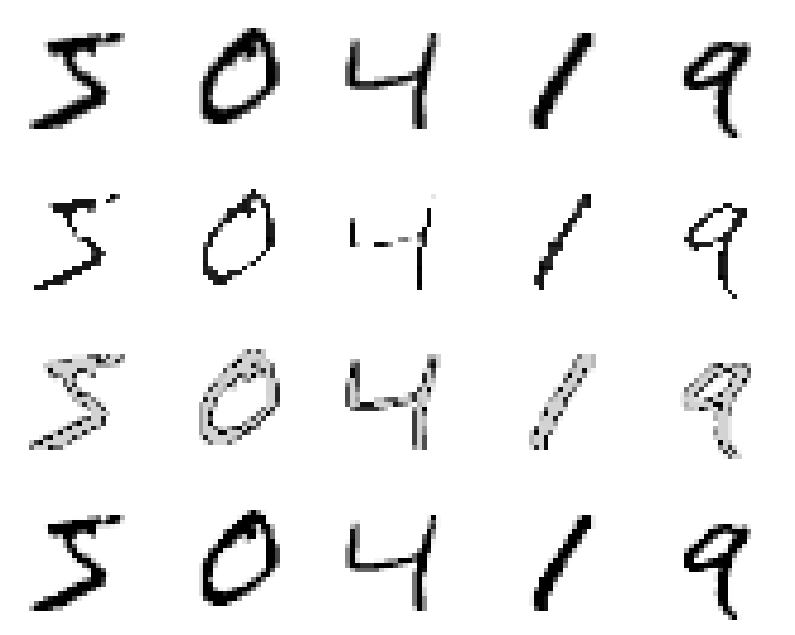

In [87]:
STEP = -0.9
x1 = x_train[:5]
x2 = x_train[:5] + STEP

x2[x2==STEP]=0.0
x2[x2<0.0]=0.0
x2[x2>1.0]=1.0

bce_loss_diff_raw = keras.losses.binary_crossentropy(x1, x2)
bce_loss_diff = tf.reduce_sum(bce_loss_diff_raw, axis=(1, 2))

print("BCE Loss",bce_loss_diff)
print("Mean BCE result",tf.reduce_mean(bce_loss_diff))


mse_loss_diff_raw = keras.losses.mse(x1, x2)
mse_loss_diff = tf.reduce_sum(mse_loss_diff_raw, axis=(1, 2))

print("MSE Loss",mse_loss_diff)
print("Mean MSE result",tf.reduce_mean(mse_loss_diff))

plot_digits(
    x1,
    x2,
    bce_loss_diff_raw.numpy(),
    mse_loss_diff_raw.numpy(),
    )

BCE Loss tf.Tensor([648.95996 706.1333  612.8812  364.3401  535.75824], shape=(5,), dtype=float32)
Mean BCE result tf.Tensor(573.61456, shape=(), dtype=float32)
MSE Loss tf.Tensor([39.454674 34.983093 26.279419 19.514614 35.59713 ], shape=(5,), dtype=float32)
Mean MSE result tf.Tensor(31.165783, shape=(), dtype=float32)


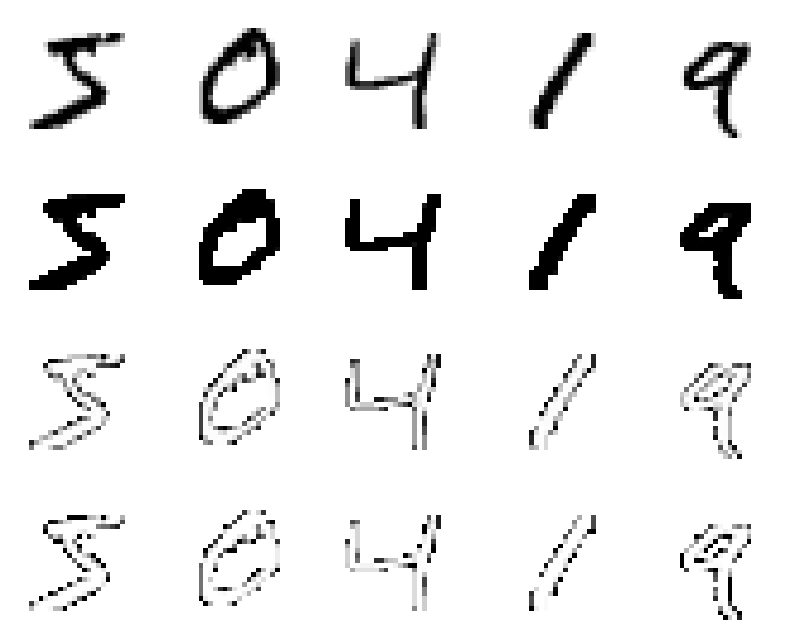

In [88]:
STEP = +0.9
x1 = x_train[:5]
x2 = x_train[:5] + STEP

x2[x2==STEP]=0.0
x2[x2<0.0]=0.0
x2[x2>1.0]=1.0

bce_loss_diff_raw = keras.losses.binary_crossentropy(x1, x2)
bce_loss_diff = tf.reduce_sum(bce_loss_diff_raw, axis=(1, 2))

print("BCE Loss",bce_loss_diff)
print("Mean BCE result",tf.reduce_mean(bce_loss_diff))


mse_loss_diff_raw = keras.losses.mse(x1, x2)
mse_loss_diff = tf.reduce_sum(mse_loss_diff_raw, axis=(1, 2))

print("MSE Loss",mse_loss_diff)
print("Mean MSE result",tf.reduce_mean(mse_loss_diff))

plot_digits(
    x1,
    x2,
    bce_loss_diff_raw.numpy(),
    mse_loss_diff_raw.numpy(),
    )